# Prompt Generator Visualization Demo

This notebook loads a prompt generator config, samples a MegaMedical image, generates prompts, and visualizes the annotations.

In [11]:

from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
import neurite as ne
import torch

repo_root = Path("/data/ddmg/mvseg-ordering")
for path in [repo_root, repo_root / "UniverSeg", repo_root / "MultiverSeg", repo_root / "ScribblePrompt",]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

from experiments.dataset.mega_medical_dataset import MegaMedicalDataset
from pylot.experiment.util import eval_config
import yaml
try:
    from scribbleprompt.analysis.plot import show_mask, show_points, show_boxes, show_scribbles
except Exception as exc:
    show_mask = show_points = show_boxes = show_scribbles = None




In [12]:
# ---- Config ----
prompt_config_dir = repo_root / "experiments/prompt_generator_configs"

# Discover all prompt config files and their keys
config_map = {}
for cfg_path in sorted(prompt_config_dir.glob("*.yml")):
    with open(cfg_path, "r", encoding="utf-8") as fh:
        cfg = yaml.safe_load(fh) or {}
    config_map[cfg_path.name] = sorted(list(cfg.keys()))

print("Available prompt generator configs + keys:")
for name, keys in config_map.items():
    print(f"- {name}: {keys}")

# Select config file + key
prompt_config_name = "bbox_prompt_generator_variants.yml"
prompt_config_key = "bbox_prompt_generator"

prompt_config_path = prompt_config_dir / prompt_config_name

# Dataset selection
# (Use dataset_target integer or task/label/slicing via MegaMedicalDataset fields)
dataset_target = 12
split = "train"
image_idx = 0  # index within the sampled dataset view

# Visualization controls
num_iterations = 3  # initial + subsequent prompts
seed = 23
np.random.seed(seed)
torch.manual_seed(seed)



Available prompt generator configs + keys:
- bbox_prompt_generator_variants.yml: ['bbox_prompt_generator']
- centerline_scribble_prompt_generator.yml: ['centerline_scribble_generator']
- click_prompt_generator.yml: ['click_generator']
- click_prompt_generator_variants.yml: ['click_generator', 'random_warm_start']
- combined_prompt_generator.yml: ['combined_prompt_generator']


In [13]:

# ---- Load dataset and prompt generator ----
ds = MegaMedicalDataset(
    dataset_target=dataset_target,
    split=split,
    dataset_size=None,
)

with open(prompt_config_path, "r", encoding="utf-8") as fh:
    raw_cfg = yaml.safe_load(fh)

prompt_generator = eval_config(raw_cfg)[prompt_config_key]
print(f"Loaded prompt generator: {prompt_config_key}")
print(f"Dataset size: {len(ds)}")


No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248
Loaded prompt generator: bbox_prompt_generator
Dataset size: 60


In [14]:
# ---- Sanity check: ensure generators are instantiated (not raw dicts) ----
import importlib
from functools import partial


def _absolute_import(reference: str):
    module, _, attr = reference.rpartition(".")
    mod = importlib.import_module(module)
    return getattr(mod, attr)


def _materialize(val):
    if isinstance(val, list):
        return [_materialize(v) for v in val]
    if isinstance(val, dict):
        # Try eval_config first
        try:
            evaluated = eval_config(val)
        except Exception:
            evaluated = val
        # If still a dict with _class/_fn, instantiate manually
        if isinstance(evaluated, dict) and ("_class" in evaluated or "_fn" in evaluated):
            if "_class" in evaluated:
                cls = _absolute_import(evaluated["_class"])
                kwargs = {k: _materialize(v) for k, v in evaluated.items() if k != "_class"}
                return cls(**kwargs)
            if "_fn" in evaluated:
                fn = _absolute_import(evaluated["_fn"])
                kwargs = {k: _materialize(v) for k, v in evaluated.items() if k != "_fn"}
                return partial(fn, **kwargs)
        return evaluated
    return val

for attr in [
    "box_generators",
    "init_pos_click_generators",
    "init_neg_click_generators",
    "correction_click_generators",
    "init_pos_scribble_generators",
    "init_neg_scribble_generators",
    "correction_scribble_generators",
]:
    if hasattr(prompt_generator, attr):
        val = getattr(prompt_generator, attr)
        fixed = _materialize(val)
        setattr(prompt_generator, attr, fixed)

print("Prompt generator sanity:")
if hasattr(prompt_generator, "box_generators"):
    bg = prompt_generator.box_generators
    if isinstance(bg, list) and bg:
        print(" box_generators[0] type:", type(bg[0]))



Prompt generator sanity:
 box_generators[0] type: <class 'scribbleprompt.interactions.boxes.UniformBBox'>


In [15]:

# ---- Get image/label ----
image, label = ds[image_idx]
image = image.to(torch.float32)
label = label.to(torch.float32)

print("image shape:", tuple(image.shape))
print("label shape:", tuple(label.shape))


image shape: (1, 128, 128)
label shape: (1, 128, 128)


In [16]:
# ---- Helpers for visualization ----



def plot_annotations(prompts, i):
    img = prompts['img'].cpu()
    seg = prompts['seg'].cpu()
    fig,axes = ne.plot.slices(
        [img, img, seg], 
        titles=[f'Input {i}', 'GT Overlayed', 'GT'], 
        do_colorbars=True, 
        width=10, 
        show=False
    )
    show_mask(seg, ax=axes[1])
    if 'point_coords' in prompts:
        show_points(prompts['point_coords'].cpu(), prompts['point_labels'].cpu(), ax=axes[0])
    if 'scribble' in prompts:
        # thresholding scribbles for visualization
        show_scribbles((prompts['scribble'].cpu() > 0), ax=axes[0])
    if 'box' in prompts:
        show_boxes(prompts['box'].cpu(), ax=axes[0])
    plt.show()



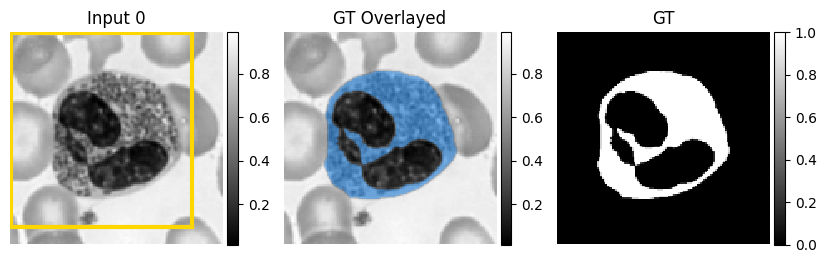

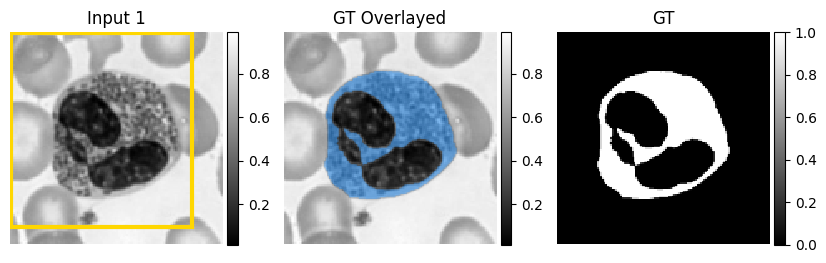

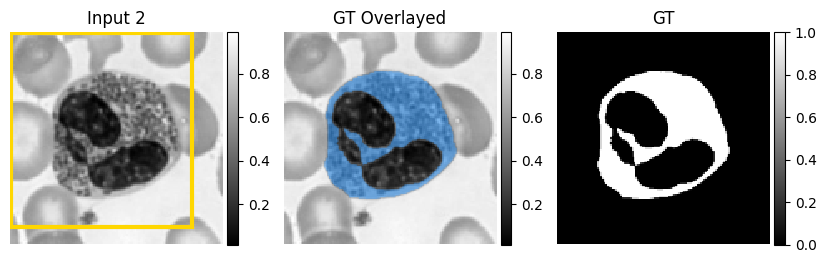

In [17]:
# ---- Generate prompts and visualize (neurite) ----
img_np = image

prompts = None
mask_pred = label[None]  # demo: use GT as mask_pred for subsequent prompts


for i in range(num_iterations):
    if i == 0:
        prompts = prompt_generator(image[None], label[None])
    else:
        prompts = prompt_generator.subsequent_prompt(
            mask_pred=mask_pred,
            prev_input=prompts,
            new_prompt=True,
        )
    
    plot_annotations(prompts, i)

torch.set_printoptions(profile="full")
